In [1]:
# Import Required Modules
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tabulate import tabulate
import joblib
from fpdf import FPDF
import tkinter as tk
from tkinter import messagebox, filedialog

In [2]:
# Extract ZIP File Locally
zip_path = 'ADL_&_Fall_Dataset_1.0.zip'
extract_to = 'ADL_Fall_Extracted'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("ZIP extraction completed.")

ZIP extraction completed.


In [3]:
# Load All CSV Files and Assign Labels
data_list = []
label_list = []
for root, dirs, files in os.walk(extract_to):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            try:
                df = pd.read_csv(file_path, header=None)
                df = df.apply(pd.to_numeric, errors='coerce')
                if df.shape[1] > 5:
                    data_list.append(df)
                    label = 1 if 'F' in file.upper() else 0
                    label_list.extend([label] * len(df))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

In [4]:
# Combine All Data into a Single DataFrame
combined_data = pd.concat(data_list, ignore_index=True)
labels = pd.Series(label_list)
combined_data = combined_data.dropna()
labels = labels.loc[combined_data.index].reset_index(drop=True)
combined_data = combined_data.reset_index(drop=True)

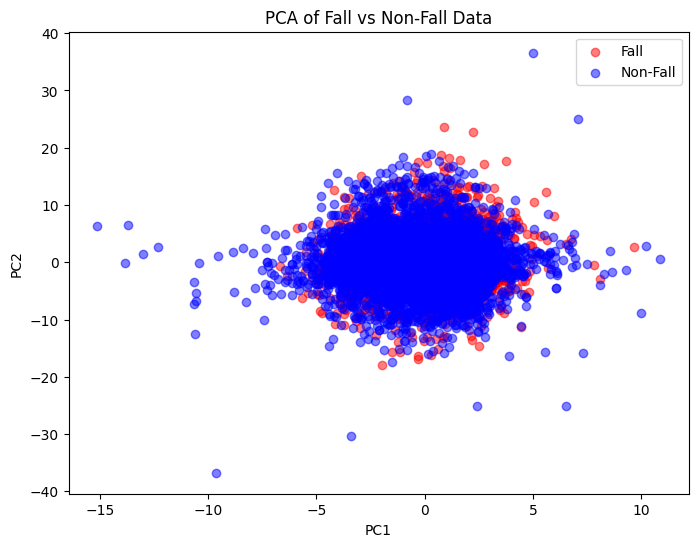

In [5]:
# PCA Visualization
X_vis = combined_data.iloc[:, 2:]
y_vis = labels
scaler_vis = StandardScaler()
X_scaled_vis = scaler_vis.fit_transform(X_vis)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_vis)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_vis == 1, 0], X_pca[y_vis == 1, 1], label='Fall', color='red', alpha=0.5)
plt.scatter(X_pca[y_vis == 0, 0], X_pca[y_vis == 0, 1], label='Non-Fall', color='blue', alpha=0.5)
plt.legend()
plt.title("PCA of Fall vs Non-Fall Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [6]:
# Supervised Classification Setup
X = combined_data.iloc[:, 2:]
y = labels

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Sample Subset for Fast Testing
sample_size = min(5000, len(X_train_scaled))
X_train_small = X_train_scaled[:sample_size]
y_train_small = y_train.iloc[:sample_size]

X_test_small = X_test_scaled[:1000]
y_test_small = y_test.iloc[:1000]


In [8]:
# Basic SVM and MLP for Faster Results
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=300)

svm_model.fit(X_train_small, y_train_small)
y_pred_svm = svm_model.predict(X_test_small)

mlp_model.fit(X_train_small, y_train_small)
y_pred_mlp = mlp_model.predict(X_test_small)

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# Evaluation Reports
report_svm = classification_report(y_test_small, y_pred_svm, output_dict=True)
report_mlp = classification_report(y_test_small, y_pred_mlp, output_dict=True)

results_df = pd.DataFrame({
    'Classifier': ['SVM', 'MLP'],
    'Accuracy': [accuracy_score(y_test_small, y_pred_svm), accuracy_score(y_test_small, y_pred_mlp)],
    'F1 Score': [report_svm['weighted avg']['f1-score'], report_mlp['weighted avg']['f1-score']],
    'Precision': [report_svm['weighted avg']['precision'], report_mlp['weighted avg']['precision']],
    'Recall': [report_svm['weighted avg']['recall'], report_mlp['weighted avg']['recall']]
})

print("Evaluation on Reduced Dataset:")
print(results_df)


Evaluation on Reduced Dataset:
  Classifier  Accuracy  F1 Score  Precision  Recall
0        SVM     0.741  0.728106   0.747041   0.741
1        MLP     0.794  0.791778   0.792775   0.794


In [10]:

# 5. Save the model and scaler
joblib.dump(scaler, 'scaler_6feat.pkl')
joblib.dump(mlp_model, 'fall_model_6feat.pkl')

['fall_model_6feat.pkl']

In [11]:
# Generate PDF Report
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, txt="Fall Detection Model Report", ln=True, align='C')

for index, row in results_df.iterrows():
    pdf.cell(200, 10, txt=f"{row['Classifier']} - Accuracy: {row['Accuracy']:.2f}, Precision: {row['Precision']:.2f}, Recall: {row['Recall']:.2f}, F1 Score: {row['F1 Score']:.2f}", ln=True)

pdf.output("fall_detection_report.pdf")

''